In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as amcols
import scipy.stats
import pandas
import agama
agama.setUnits(mass = 1, length = 1, velocity = 1)
import bibimbpy
import os, time, warnings
from configparser import RawConfigParser  # python 2

In [2]:
r_ic = 8.275
phi_ic = -30
z_ic = 0.015
vz_ic = 8.59
vrmax,vrmin = 80,-80
vphimax,vphimin = 330,110
vr_ic = np.linspace(vrmin,vrmax,200)
vphi_ic = np.linspace(vphimin,vphimax,200)
pattern_speed = 37

In [3]:
def get_Ab(t,Af,t1):
    def aux_func(t,t1):
        return 2*t/t1-1
    aux = aux_func(t,t1)    
    return Af*(3/16*aux**5-5/8*aux**3+15/16*aux+1/2)
def get_Af(alfa,v0,R0,Rb):
    return alfa*v0**2/3*(R0/Rb)**3
def get_Rc(R0,v0,beta,Omegab):
    Omega0 = v0/R0
    return R0*(Omegab/Omega0)**(1/(beta-1))
def get_Rolr(R0,v0,beta,Omegab):
    Omega0 = v0/R0
    return R0*(Omega0/Omegab*(1+np.sqrt((1+beta)/2)))**(1/(1-beta))
def get_omegabar(R0,Rolr,v0,beta):
    Omega0 = v0/R0
    return Omega0*(1+np.sqrt((1+beta)/2))/(Rolr/R0)**(1-beta)

In [4]:
R0 = 8
v0 = 240
beta = 0.0
Rolr = 0.9*R0
Omegab = get_omegabar(R0,Rolr,v0,beta)
Rc = get_Rc(R0,v0,beta,Omegab)
Rb = Rc*0.8
alfa = 0.01
Tb = 2*np.pi/Omegab
t2 = 4*Tb
t1 = 0.5*t2
Af = get_Af(alfa,v0,R0,Rb)
#Ab = get_Ab(t,Af,t1)
print(Omegab, Tb, Af)

56.903559372884914 0.11041814214127321 2559.0914270333933


In [5]:
ic,(var1,var2) = bibimbpy.initialize.set_initial_conditions(r_ic,phi_ic,z_ic,vr_ic,vphi_ic,vz_ic)

In [6]:
pbase_params = {"file":"./MWPotentialHunter24_full.ini"}

In [7]:
Pot_Axisym   =agama.Potential(**pbase_params)

In [8]:
bibimbpy.utils.generate_scaling_file(t1,"dehnen",1000,"dehnen00_scaling_1.txt")

In [9]:
Bar_params           = {"file":"./PotLib_BAR_.ini",               "scale":"dehnen00_scaling_1.txt"}
Spiral_params        = {"file":"./MWPotentialHunter24_spiral.ini","scale":"dehnen00_scaling_1.txt"}
NonAxisym_params     = {"file":"./PotLib_Axisym_.ini",            "scale":"dehnen00_scaling_1.txt"}

In [10]:
Pot_Axisym_1,  Pot_Spiral      = bibimbpy.initialize.generate_Pot(pbase_params,  Spiral_params    ,_rmin=0.5)
Pot_Axisym_2,  Pot_Bar         = bibimbpy.initialize.generate_Pot(pbase_params,  Bar_params       ,_rmin=0.5)
Pot_Axisym_3,  Pot_NonAxisym   = bibimbpy.initialize.generate_Pot(pbase_params,  NonAxisym_params ,_rmin=0.5)

In [11]:
iniFileName =  "./QDF.ini"
ini = RawConfigParser()
ini.optionxform=str  # do not convert key to lowercase
ini.read(iniFileName)

['./QDF.ini']

In [12]:
iniDFthinDisk    = dict(ini.items("DF thin disk"))
iniDFthickDisk   = dict(ini.items("DF thick disk"))

In [13]:
df_thick = agama.DistributionFunction(potential=Pot_Axisym, **iniDFthickDisk)
df_thin  = agama.DistributionFunction(potential=Pot_Axisym, **iniDFthinDisk)

In [14]:
def DF_EVAL_Spiral_Thick(points):
    af = agama.ActionFinder(Pot_Axisym_1)
    actions = af(points)
    return df_thick(actions)
def DF_EVAL_BAR_Thick(points):
    af = agama.ActionFinder(Pot_Axisym_2)
    actions = af(points)
    return df_thick(actions)
def DF_EVAL_NonAxis_Thick(points):
    af = agama.ActionFinder(Pot_Axisym_3)
    actions = af(points)
    return df_thick(actions)

In [15]:
def DF_EVAL_Spiral_Thin(points):
    af = agama.ActionFinder(Pot_Axisym_1)
    actions = af(points)
    return df_thin(actions)
def DF_EVAL_BAR_Thin(points):
    af = agama.ActionFinder(Pot_Axisym_2)
    actions = af(points)
    return df_thin(actions)
def DF_EVAL_NonAxis_Thin(points):
    af = agama.ActionFinder(Pot_Axisym_3)
    actions = af(points)
    return df_thin(actions)

In [16]:
DF_E_Spiral_Thin,t_Spiral_Thin, orbits_Spiral_Thin =             bibimbpy.orbits.runBI(
                                                                 ic,
                                                                 Pot_Spiral,
                                                                 DF_EVAL_Spiral_Thin,
                                                                 t2,t2,pattern_speed)
DF_E_Bar_Thin,t_Bar_Thin, orbits_Bar_Thin                      = bibimbpy.orbits.runBI(
                                                                 ic,
                                                                 Pot_Bar,
                                                                 DF_EVAL_BAR_Thin,
                                                                 t2,t2,pattern_speed)
DF_E_NonAxis_Thin,t_NonAxis_Thin, orbits_NonAxis_Thin          = bibimbpy.orbits.runBI(
                                                                 ic,
                                                                 Pot_NonAxisym,
                                                                 DF_EVAL_NonAxis_Thin,
                                                                 t2,t2,pattern_speed)

40000 orbits complete (1053 orbits/s)
40000 orbits complete (666.7 orbits/s)


In [17]:
DF_E_Spiral_Thick,t_Spiral_Thick, orbits_Spiral_Thick =          bibimbpy.orbits.runBI(
                                                                 ic,
                                                                 Pot_Spiral,
                                                                 DF_EVAL_Spiral_Thick,
                                                                 t2,t2,pattern_speed)
DF_E_Bar_Thick,t_Bar_Thick, orbits_Bar_Thick                      = bibimbpy.orbits.runBI(
                                                                 ic,
                                                                 Pot_Bar,
                                                                 DF_EVAL_BAR_Thick,
                                                                 t2,t2,pattern_speed)
DF_E_NonAxis_Thick,t_NonAxis_Thick, orbits_NonAxis_Thick          = bibimbpy.orbits.runBI(
                                                                 ic,
                                                                 Pot_NonAxisym,
                                                                 DF_EVAL_NonAxis_Thick,
                                                                 t2,t2,pattern_speed)

40000 orbits complete (211.6 orbits/s)
40000 orbits complete (231.2 orbits/s)
40000 orbits complete (666.7 orbits/s)


In [18]:
df_sum_Spiral_Thin,vre_Spiral_Thin,vphie_Spiral_Thin     = bibimbpy.utils.DFhistogram2d(
                                                           var1,var2,DF_E_Spiral_Thin,bins=(vr_ic,vphi_ic))
df_sum_Bar_Thin,vre_Bar_Thin,vphie_Bar_Thin              = bibimbpy.utils.DFhistogram2d(
                                                           var1,var2,DF_E_Bar_Thin,bins=(vr_ic,vphi_ic))
df_sum_NonAxis_Thin,vre_NonAxis_Thin,vphie_NonAxis_Thin  = bibimbpy.utils.DFhistogram2d(
                                                           var1,var2,DF_E_NonAxis_Thin,bins=(vr_ic,vphi_ic))

In [19]:
df_sum_Spiral_Thick,vre_Spiral_Thick,vphie_Spiral_Thick     = bibimbpy.utils.DFhistogram2d(
                                                           var1,var2,DF_E_Spiral_Thick,bins=(vr_ic,vphi_ic))
df_sum_Bar_Thick,vre_Bar_Thick,vphie_Bar_Thick              = bibimbpy.utils.DFhistogram2d(
                                                           var1,var2,DF_E_Bar_Thick,bins=(vr_ic,vphi_ic))
df_sum_NonAxis_Thick,vre_NonAxis_Thick,vphie_NonAxis_Thick  = bibimbpy.utils.DFhistogram2d(
                                                           var1,var2,DF_E_NonAxis_Thick,bins=(vr_ic,vphi_ic))

In [20]:
VR_Spiral_Thin,VPHI_Spiral_Thin = np.meshgrid(0.5*(vre_Spiral_Thin[1:]+vre_Spiral_Thin[:-1]),0.5*(vphie_Spiral_Thin[1:]+vphie_Spiral_Thin[:-1]))
VR_Bar_Thin,VPHI_Bar_Thin = np.meshgrid(0.5*(vre_Bar_Thin[1:]+vre_Bar_Thin[:-1]),0.5*(vphie_Bar_Thin[1:]+vphie_Bar_Thin[:-1]))
VR_NonAxis_Thin,VPHI_NonAxis_Thin = np.meshgrid(0.5*(vre_NonAxis_Thin[1:]+vre_NonAxis_Thin[:-1]),0.5*(vphie_NonAxis_Thin[1:]+vphie_NonAxis_Thin[:-1]))

In [21]:
VR_Spiral_Thick,VPHI_Spiral_Thick = np.meshgrid(0.5*(vre_Spiral_Thick[1:]+vre_Spiral_Thick[:-1]),0.5*(vphie_Spiral_Thick[1:]+vphie_Spiral_Thick[:-1]))
VR_Bar_Thick,VPHI_Bar_Thick = np.meshgrid(0.5*(vre_Bar_Thick[1:]+vre_Bar_Thick[:-1]),0.5*(vphie_Bar_Thick[1:]+vphie_Bar_Thick[:-1]))
VR_NonAxis_Thick,VPHI_NonAxis_Thick = np.meshgrid(0.5*(vre_NonAxis_Thick[1:]+vre_NonAxis_Thick[:-1]),0.5*(vphie_NonAxis_Thick[1:]+vphie_NonAxis_Thick[:-1]))

In [22]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

In [23]:
import matplotlib
import pandas as pd
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
SMALL_SIZE =  22
MEDIUM_SIZE = 22
BIGGER_SIZE = 15
SMALL_SIZE =  18
MEDIUM_SIZE = 22
BIGGER_SIZE = 15
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter
plt.rc('font', size=90)          # controls default text sizes
plt.rc('axes', titlesize=90)     # fontsize of the axes title
plt.rc('axes', labelsize=90)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=90)    # fontsize of the tick labels
plt.rc('ytick', labelsize=90)    # fontsize of the tick labels
plt.rc('legend', fontsize=90)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', linewidth=10)
plt.rc('font', weight='medium',style='normal',family='Arial')
G=4.321
from matplotlib import cm
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

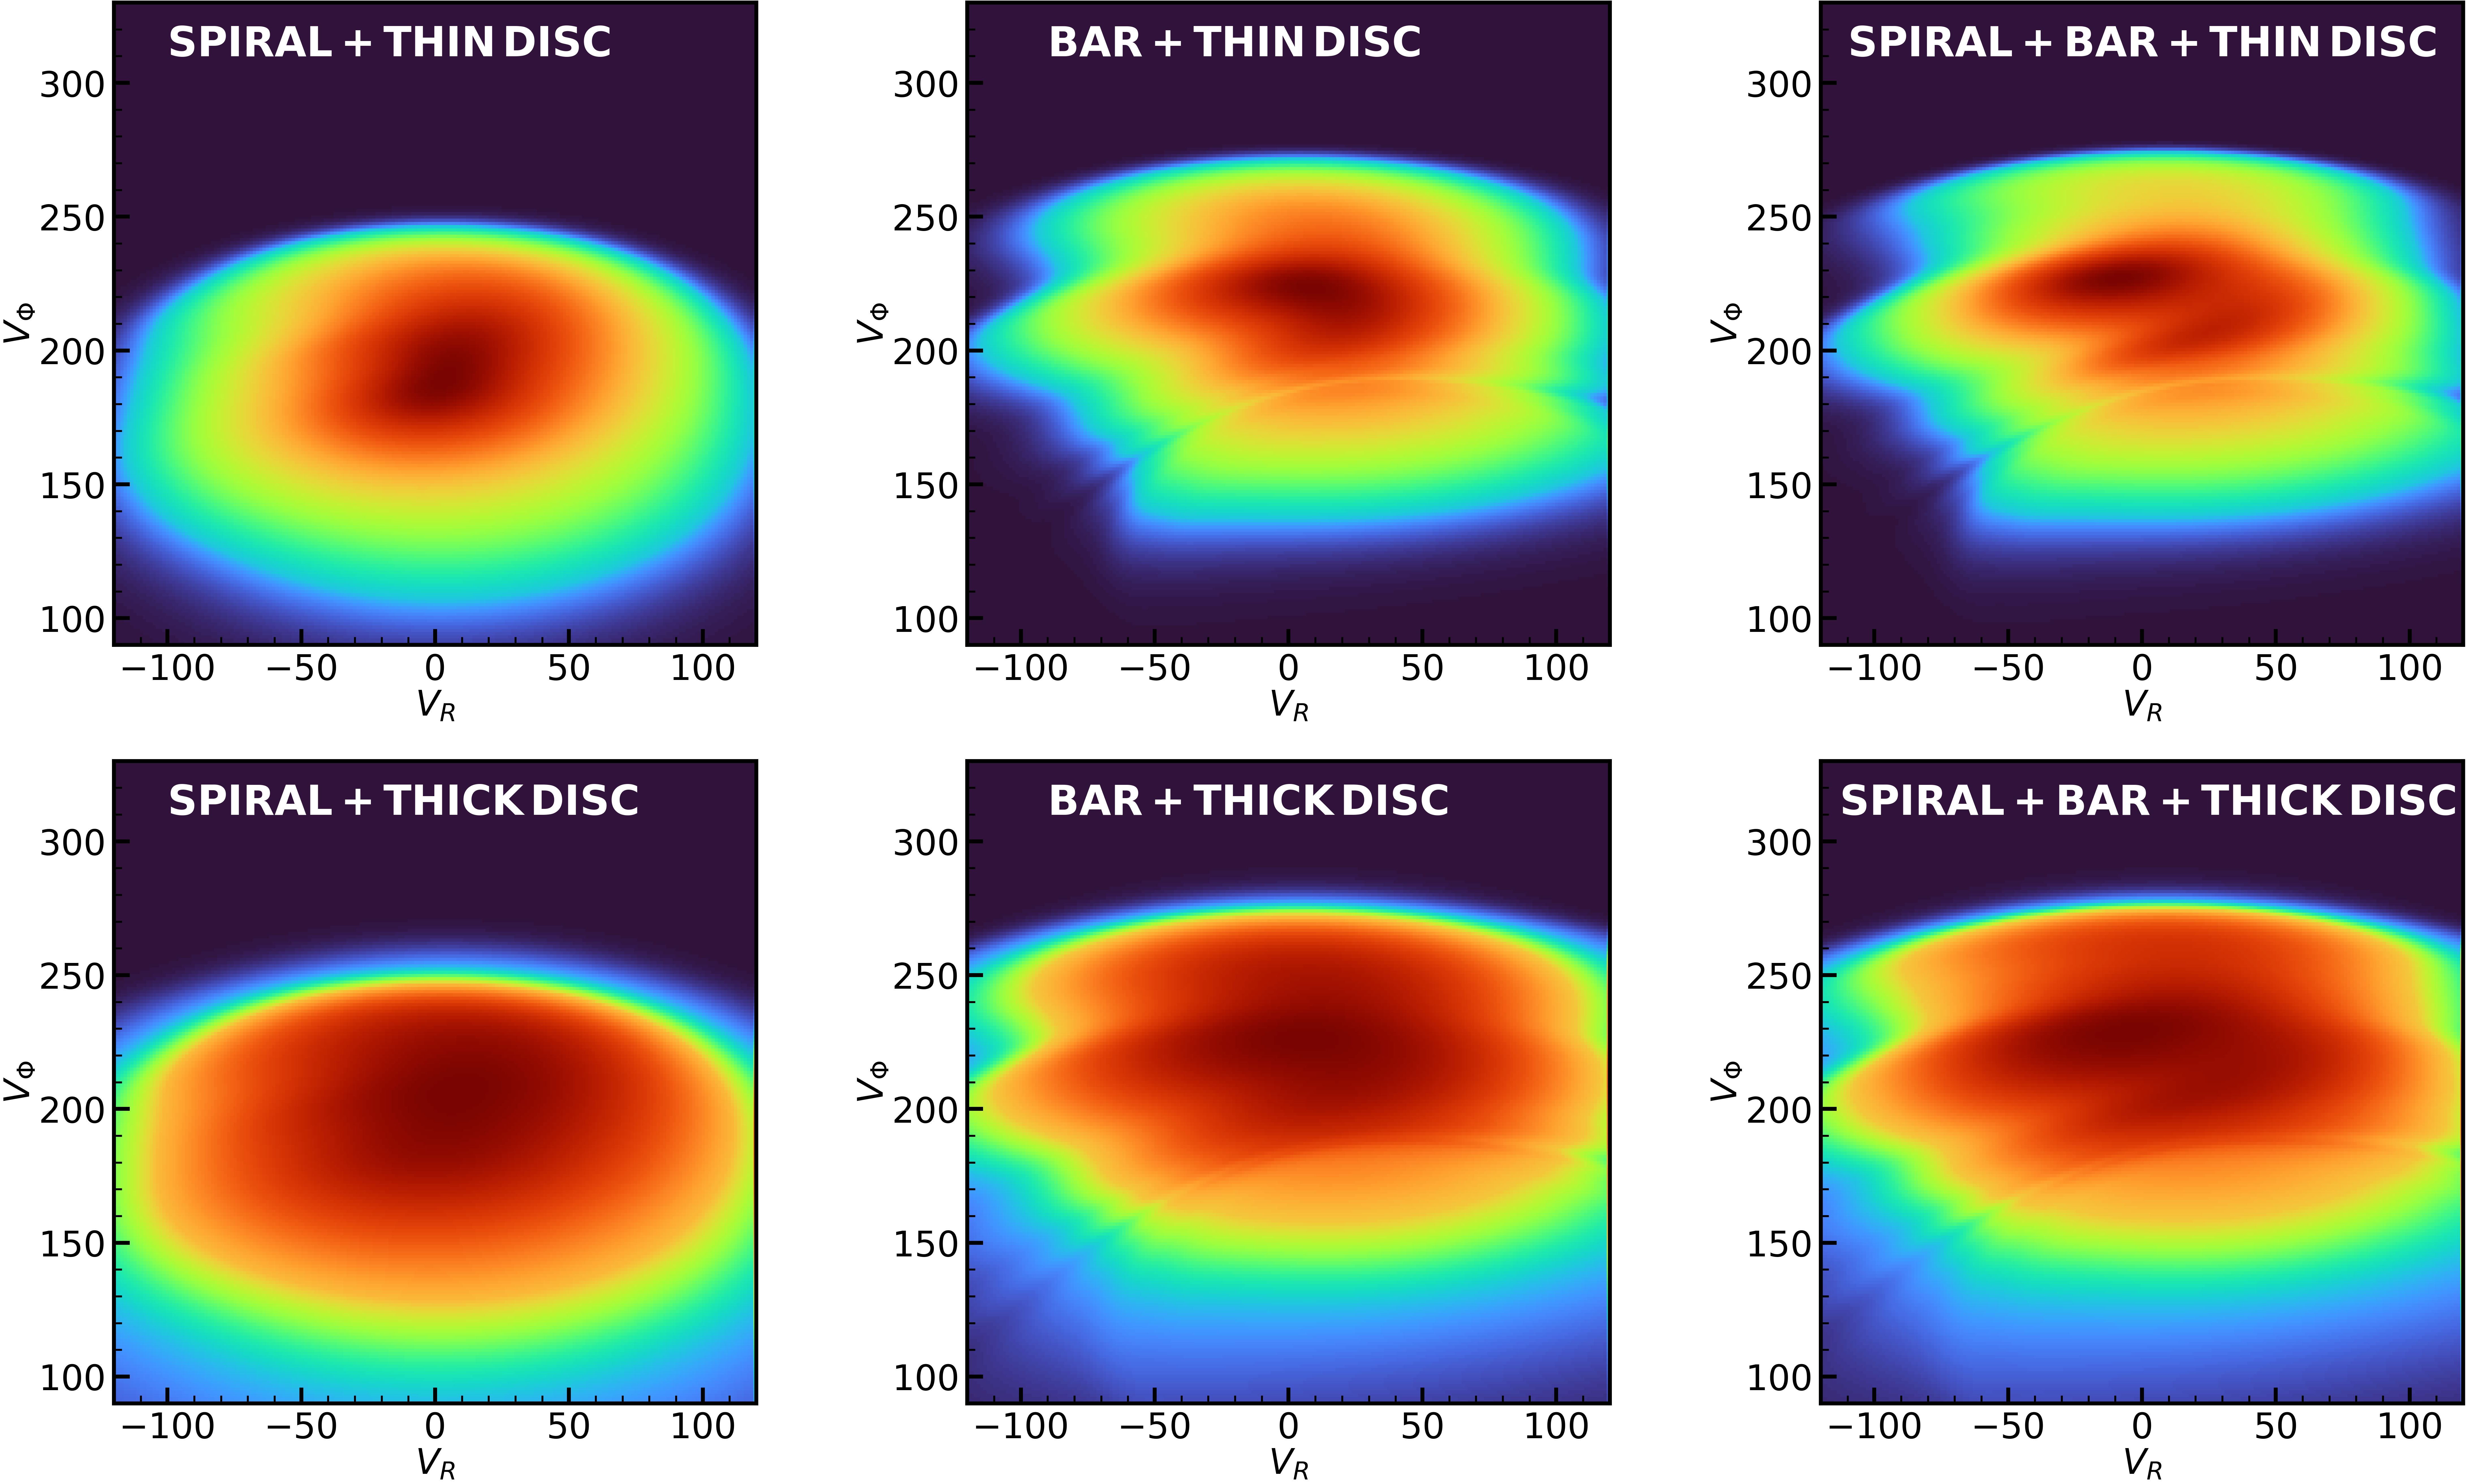

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(95,55))


ax[0,0].minorticks_on()
ax[0,0].tick_params('both', length=40, width=10, which='major', direction="in", pad=20)
ax[0,0].tick_params('both', length=20, width=5, which='minor', direction="in", pad=20)
ax[0,1].minorticks_on()
ax[0,1].tick_params('both', length=40, width=10, which='major', direction="in", pad=20)
ax[0,1].tick_params('both', length=20, width=5, which='minor', direction="in", pad=20)
ax[0,2].minorticks_on()
ax[0,2].tick_params('both', length=40, width=10, which='major', direction="in", pad=20)
ax[0,2].tick_params('both', length=20, width=5, which='minor', direction="in", pad=20)
ax[1,0].minorticks_on()
ax[1,0].tick_params('both', length=40, width=10, which='major', direction="in", pad=20)
ax[1,0].tick_params('both', length=20, width=5, which='minor', direction="in", pad=20)
ax[1,1].minorticks_on()
ax[1,1].tick_params('both', length=40, width=10, which='major', direction="in", pad=20)
ax[1,1].tick_params('both', length=20, width=5, which='minor', direction="in", pad=20)
ax[1,2].minorticks_on()
ax[1,2].tick_params('both', length=40, width=10, which='major', direction="in", pad=20)
ax[1,2].tick_params('both', length=20, width=5, which='minor', direction="in", pad=20)
ax[1,0].set_xlabel('$V_{R}$')
ax[1,0].set_ylabel('$V_{\Phi}$')
ax[1,1].set_xlabel('$V_{R}$')
ax[1,1].set_ylabel('$V_{\Phi}$')
ax[1,2].set_xlabel('$V_{R}$')
ax[1,2].set_ylabel('$V_{\Phi}$')
ax[0,0].set_xlabel('$V_{R}$')
ax[0,0].set_ylabel('$V_{\Phi}$')
ax[0,1].set_xlabel('$V_{R}$')
ax[0,1].set_ylabel('$V_{\Phi}$')
ax[0,2].set_xlabel('$V_{R}$')
ax[0,2].set_ylabel('$V_{\Phi}$')


Spiral_Thin                 = ax[0,0].imshow(df_sum_Spiral_Thin.T, 
                            interpolation='nearest', origin='lower', 
                            aspect="equal", cmap=plt.cm.turbo, 
                            norm = mpl.colors.SymLogNorm(linthresh=10**0,
                            linscale=10**0, vmin=0, vmax=np.max(df_sum_Spiral_Thin.T), 
                                                         base=10), extent=extent)


Bar_Thin                    = ax[0,1].imshow(df_sum_Bar_Thin.T, 
                            interpolation='nearest', origin='lower', 
                            aspect="equal", cmap=plt.cm.turbo, 
                            norm = mpl.colors.SymLogNorm(linthresh=10**0,
                            linscale=10**0, vmin=0, vmax=np.max(df_sum_Bar_Thin.T), 
                                                         base=10), extent=extent)


NonAxis_Thin                = ax[0,2].imshow(df_sum_NonAxis_Thin.T, 
                            interpolation='nearest', origin='lower', 
                            aspect="equal", cmap=plt.cm.turbo, 
                            norm = mpl.colors.SymLogNorm(linthresh=10**0,
                            linscale=10**0, vmin=0, vmax=np.max(df_sum_NonAxis_Thin.T), 
                                                         base=10), extent=extent)




Spiral_Thick                 = ax[1,0].imshow(df_sum_Spiral_Thick.T, 
                            interpolation='nearest', origin='lower', 
                            aspect="equal", cmap=plt.cm.turbo, 
                            norm = mpl.colors.SymLogNorm(linthresh=10**0,
                            linscale=10**0, vmin=0, vmax=np.max(df_sum_Spiral_Thick.T), 
                                                         base=10), extent=extent)


Bar_Thick                    = ax[1,1].imshow(df_sum_Bar_Thick.T, 
                            interpolation='nearest', origin='lower', 
                            aspect="equal", cmap=plt.cm.turbo, 
                            norm = mpl.colors.SymLogNorm(linthresh=10**0,
                            linscale=10**0, vmin=0, vmax=np.max(df_sum_Bar_Thick.T), 
                                                         base=10), extent=extent)






NonAxis_Thick                = ax[1,2].imshow(df_sum_NonAxis_Thick.T, 
                            interpolation='nearest', origin='lower', 
                            aspect="equal", cmap=plt.cm.turbo, 
                            norm = mpl.colors.SymLogNorm(linthresh=10**0,
                            linscale=10**0, vmin=0, vmax=np.max(df_sum_NonAxis_Thick.T), 
                                                         base=10), extent=extent)




ax[0,0].annotate('$\mathbf{SPIRAL+THIN \,DISC}$',(-100,310),fontsize=105,color='white')
ax[0,1].annotate('$\mathbf{BAR+THIN \,DISC}$',(-90,310),fontsize=105,color='white')
ax[0,2].annotate('$\mathbf{SPIRAL+BAR+THIN \,DISC}$',(-110,310),fontsize=105,color='white')
ax[1,0].annotate('$\mathbf{SPIRAL+THICK \,DISC}$',(-100,310),fontsize=105,color='white')
ax[1,1].annotate('$\mathbf{BAR+THICK \,DISC}$',(-90,310),fontsize=105,color='white')
ax[1,2].annotate('$\mathbf{SPIRAL+BAR+THICK \,DISC}$',(-113,310),fontsize=105,color='white')

plt.tight_layout()
plt.savefig('Initial.pdf',dpi=300)